## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from IPython.display import clear_output

In [2]:
import string
import os
import re
import json
import random
from random import sample

from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(list(map(lambda x: x.lower(), text)))

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text_p = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
with open('./pushkin_by_verse.json', 'r') as iofile:
    text_pushkin = json.load(iofile)

### New School Artists

In [7]:
with open('./full_songs_by_artist.json', 'r') as iofile:
    text_songs = json.load(iofile)
# text_songs = "".join(list(map(lambda x: x.lower(), text_songs)))

In [8]:
text = []
for val in text_songs.values():
    for txt in val.values():
        text.append(txt)

In [9]:
text = list(map(lambda x: re.split(r"(\n{3})", x), text))

In [10]:
rez_text = []
for song in text:
    rez_text.extend(list(filter(lambda x: x != "", song)))

In [11]:
len(rez_text)

1221

text_songs - lyrics from Genius.com featuring these artists from New School: 
* Eldzhey
* LSP
* Morgenstern
* Oxxxymiron
* Slava KPSS
* Yanix
* Noize MC
* GONE.Fludd
* Big Baby Tape

### So, full text contains Onegin + some russian rappers

In [156]:
full_text = text_pushkin + rez_text

Put all the characters, that you've seen in the text, into variable `tokens`.

In [171]:
text = list(map(lambda x: re.sub(r"\xa0", " ", re.sub(r"\u2005|\u205f", "", x.lower())), full_text))

In [172]:
tokens = sorted(set("".join(text)))

In [173]:
num_tokens = len(tokens)

In [174]:
num_tokens

106

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [175]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: idx for idx, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: char for char, idx in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [162]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [163]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [165]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(
            embedding_size + rnn_num_units,
            rnn_num_units
        )
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next) 
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [166]:
KARPATHY_CONSTANT = 3e-4

In [167]:
def to_matrix(words, batch_size, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        line_ix = [token_to_idx[c] for c in words[i]]
        words_ix[i, :len(line_ix)] = line_ix[:max_len]
        
    if not batch_first: # convert [batch, time] into [time, batch]
        words_ix = np.transpose(words_ix)
    if words_ix.shape[0] < batch_size:
        words_ix = np.vstack((words_ix, np.ones((batch_size - words_ix.shape[0], max_len)) * pad))
    return words_ix

In [32]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in words_ix
    :param words_ix: an int32 matrix of shape [batch, time], output of to_matrix(words)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state) 
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [168]:
MAX_LENGTH = 512

In [169]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [28]:
BATCH_SIZE = 32
EPOCHS = 10000

In [424]:
char_rnn = CharRNNCell(num_tokens=num_tokens, embedding_size=64, rnn_num_units=128)
criterion = nn.NLLLoss()

In [562]:
opt = torch.optim.Adam(char_rnn.parameters(), lr=3e-4)
# scheduler = StepLR(opt, step_size=2500)

In [426]:
(len(text) // BATCH_SIZE + 1) * EPOCHS

5000

In [155]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(char_rnn, to_matrix(text[0: BATCH_SIZE], BATCH_SIZE, max_len=MAX_LENGTH))
writer.close()

In [154]:
%load_ext tensorboard
%tensorboard --logdir runs

In [610]:
history = []
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    train_history = []
    char_rnn.train()
    for i in range(len(text) // BATCH_SIZE + 1):
        batch_ix = to_matrix(text[i * BATCH_SIZE: i * BATCH_SIZE + BATCH_SIZE], BATCH_SIZE, max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        logp_seq = rnn_loop(char_rnn, batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]
        loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                      actual_next_tokens.contiguous().view(-1))

        loss.backward()
        opt.step()
        opt.zero_grad()

        train_history.append(loss.data.numpy())
        if (i+1)%5==0:
            clear_output(True)
            plt.plot(train_history,label='loss')
            plt.legend()
            plt.show()
    if np.mean(train_history) < best_valid_loss:
        best_valid_loss = np.mean(train_history)
        torch.save(char_rnn.state_dict(), './char_rnn_1.pt')
        
    history.append(train_history)
    writer.add_scalar('mean train loss per epoch', np.mean(train_history), global_step=epoch)
    char_rnn.eval()
    writer.add_text('generation example',
                    generate_sample(char_rnn=char_rnn, seed_phrase="мой дядя самых честных правил", max_length=512, temperature=0.2), 
                    global_step=epoch)
    writer.close()
#     print(generate_sample(char_rnn=char_rnn, seed_phrase="мой дядя самых честных правил", max_length=512, temperature=0.2))
#     print(f"epoch {epoch + 1} mean loss: {np.mean(history)}")
#     scheduler.step()
#     assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [251]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, dropout=0.2, num_layers=1):
        super(self.__class__, self).__init__()
        self.lstm_size = rnn_num_units
        self.num_layers = num_layers
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h, c):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, hn_cn = self.rnn(self.emb(x), (h, c))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hn_cn
    
    def initial_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

In [253]:
BASE_LR = 1e-2
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING_SIZE = 64
HIDDEN_SIZE = 128
DROPOUT = 0
NUM_LAYERS = 1

In [255]:
char_lstm = CharRNNLoop(num_tokens=num_tokens, emb_size=EMBEDDING_SIZE, rnn_num_units=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT)
char_lstm.load_state_dict(torch.load("./char_lstm_1.pt"))
char_lstm.eval()

CharRNNLoop(
  (emb): Embedding(106, 64)
  (rnn): LSTM(64, 128, batch_first=True)
  (hid_to_logits): Linear(in_features=128, out_features=106, bias=True)
)

In [112]:
# char_lstm = CharRNNLoop(num_tokens=num_tokens, emb_size=EMBEDDING_SIZE, rnn_num_units=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT)
opt = torch.optim.Adam(char_lstm.parameters(), lr=BASE_LR)
criterion = nn.NLLLoss()

In [153]:
lstm_writer = SummaryWriter()
lstm_writer.add_graph(char_lstm, to_matrix(text[0: BATCH_SIZE], BATCH_SIZE, max_len=MAX_LENGTH))
lstm_writer.close()

In [152]:
%reload_ext tensorboard
%tensorboard --logdir runs

In [115]:
def generate_sample_lstm(char_lstm, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    char_lstm.eval()
    h_0, c_0 = char_lstm.initial_state(1)

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    
    #feed the seed phrase, if any
    logp_next, hn_cn = char_lstm(x_sequence, h_0, c_0)
    p_next = F.softmax(logp_next[0, -1, :] / temperature, dim=0).data.numpy()
    next_ix = np.random.choice(num_tokens,p=p_next)
    next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
    chars = [next_ix]
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hn_cn = char_lstm(chars[-1], *hn_cn)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        chars.append(next_ix)
        
    return seed_phrase + ''.join([tokens[ix.data.numpy()[0][0]] for ix in chars])

In [116]:
(len(text) // BATCH_SIZE + 1) * EPOCHS

5880

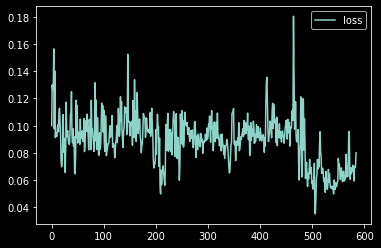

In [117]:
history = []
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    train_history = []
    char_lstm.train()
    for i in range(len(text) // BATCH_SIZE + 1):
        batch_ix = to_matrix(text[i * BATCH_SIZE: i * BATCH_SIZE + BATCH_SIZE], BATCH_SIZE, max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        h_0, c_0 = char_lstm.initial_state(BATCH_SIZE)
        logp_seq, hn_cn = char_lstm(batch_ix, h_0, c_0)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]
        loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                      actual_next_tokens.contiguous().view(-1))

        loss.backward()
        opt.step()
        opt.zero_grad()

        train_history.append(loss.data.numpy())
        if (i+1)%5==0:
            clear_output(True)
            plt.plot(train_history,label='loss')
            plt.legend()
            plt.show()
    if np.mean(train_history) < best_valid_loss:
        best_valid_loss = np.mean(train_history)
        torch.save(char_lstm.state_dict(), f'./char_lstm_1_EMBD{EMBEDDING_SIZE}_BATCH{BATCH_SIZE}_HID{HIDDEN_SIZE}.pt')
        
    history.append(train_history)
    lstm_writer.add_scalar('mean train loss per epoch', np.mean(train_history), global_step=epoch)
    lstm_writer.add_text('generation example',
                    generate_sample_lstm(char_lstm=char_lstm, seed_phrase="мой дядя самых честных правил", max_length=512, temperature=0.2), 
                    global_step=epoch)
    lstm_writer.close()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [256]:
best_char_rnn = CharRNNCell(num_tokens=num_tokens, embedding_size=64, rnn_num_units=128)
best_char_rnn.load_state_dict(torch.load("./char_rnn_1.pt"))
best_char_rnn.eval()

CharRNNCell(
  (embedding): Embedding(106, 64)
  (rnn_update): Linear(in_features=192, out_features=128, bias=True)
  (rnn_to_logits): Linear(in_features=128, out_features=106, bias=True)
)

In [275]:
print("RNN:")
for temp in [0.1, 0.2, 0.5, 1., 2.]:
    print(f"temperature: {temp}")
    print(generate_sample(char_rnn=best_char_rnn, seed_phrase="мой дядя ", max_length=512, temperature=temp) + "\n")

RNN:
temperature: 0.1
мой дядя в темноте не страшно на мне под подошвы дальной странный делать за стать в темноте всё был с подожденной под подошвы дальной странный века не скажется в темноте всё был и странный как города (почему?) хе-путину мой как будто полно на мне под подошвы дальной странный красивый собой половать делать за стать в том под подошвы дальной странный как гром (эйби)
так подруг на балковали на мне под подошвы дальной странный красивый сердце под мог не полете в темноте всё гости с похоток (грустные танцы)
я не

temperature: 0.2
мой дядя в моей стал (ха-ха)
я и думал в моей черепит на стреляю своей не дайти (сук, пока под подошвы далью душах под подоры, на под подошвой
пора под подоры, старавил бы в как будто половек в руке себе не подождёным на себя в самом домит и все не породительный колет и думать
и в семья места
я не встафетской доми доми на собой, но ты подруг и мой бетлон (ага)
так скупка на мне полно просто в самом колим он под подошвы дальной строй — мне не с

In [277]:
best_char_lstm = CharRNNLoop(num_tokens=num_tokens, emb_size=EMBEDDING_SIZE, rnn_num_units=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT)
best_char_lstm.load_state_dict(torch.load("./char_lstm_1.pt"))
best_char_lstm.eval()

CharRNNLoop(
  (emb): Embedding(106, 64)
  (rnn): LSTM(64, 128, batch_first=True)
  (hid_to_logits): Linear(in_features=128, out_features=106, bias=True)
)

In [283]:
print("LSTM:")
for temp in [0.1, 0.2, 0.5, 1., 2.]:
    print(f"temperature: {temp}")
    print(generate_sample_lstm(char_lstm=best_char_lstm, seed_phrase="мой дядя ", max_length=512, temperature=temp) + "\n")

LSTM:
temperature: 0.1
мой дядя в моей музыкой красивой
в сердце не в комнате, чем темнотах на мои был не старины
в тишине, если с тобой должно не надо след
когда грустно по небо не старин
и полно под кругу под миним должно
я вижу и только со мной — это мне не старин
поле совсем не про нас нет, а я не выходим был обезорые кругом
старина ты половей
с тобой бедной реденный города и под каконе
на груди, на запястье, на груди, на запястье
тут страстей своей странной
в темноте не старик ль в темноте, не видит подошвой
под кровью под кр

temperature: 0.2
мой дядя в сети
что ты будешь делать с этим? (сети-сети-сети-сети)                                                                                                                                                                                                                                                                                                                                                                                           

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)